
## How to Use the Notebooks

To run these notebooks, follow these steps:


### 1. Install **`gdal`** Package
Installing `gdal` via `pip` may fail. Therefore, we recommend using conda to install it:
```bash
conda install gdal -c conda-forge
```

### 2. Install **`polsartools`** Package

Before running the notebooks, you'll need to install the core **`polsartools`** package. 

**Option A:** Install from PyPI `pip` (stable release)

```bash
pip install polsartools
```

**Option B:** Install from conda (stable release)

```bash
conda install polsartools -c bnarayanarao
```


**Option C:**  Install the latest version from GitHub (if you need recent updates or fixes)

```bash
pip install git+https://github.com/Narayana-Rao/polsartools.git#egg=polsartools
```
> **Note:** If you encounter a `"module not found"` error or require newer features, prefer the **Option C**.

### 3. Verify the Installation

After successfully installing `polsartools`, you can verify it by importing the package:

```bash
import polsartools as pst
```

If this runs without errors, you're ready to explore and run the notebooks.




In [1]:
""" 
import required packages
"""

import os
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import polsartools as pst
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module='pyproj')


In [2]:
""" 

Function to display images

"""

def plot_images(*filenames, lower_percentile=2, upper_percentile=98, max_cols=4):
    def compute_vmin_vmax(data):
        data_no_nan = data[np.isfinite(data)]
        vmin = np.percentile(data_no_nan, lower_percentile)
        vmax = np.percentile(data_no_nan, upper_percentile)
        return vmin, vmax

    num_images = len(filenames)

    if num_images == 1:
        # Single image case
        data = pst.read_rst(filenames[0])
        data[data==0]=np.nan
        vmin, vmax = compute_vmin_vmax(data)

        fig, ax = plt.subplots(figsize=(6, 6))
        im = ax.imshow(data, vmin=vmin, vmax=vmax)
        ax.set_title(os.path.basename(filenames[0]))
        fig.colorbar(im, ax=ax)
        plt.tight_layout()
        plt.show()
    else:
        # Multiple image case
        ncols = min(max_cols, num_images)
        nrows = int(np.ceil(num_images / ncols))

        fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
        axes = np.array(axes).reshape(-1)  # Flatten in case it's a 2D grid

        for i, filename in enumerate(filenames):
            data = pst.read_rst(filename)
            data[data==0]=np.nan
            vmin, vmax = compute_vmin_vmax(data)
            ax = axes[i]
            im = ax.imshow(data, vmin=vmin, vmax=vmax)
            ax.set_title(os.path.basename(filename))
            fig.colorbar(im, ax=ax)

        for j in range(num_images, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()


#### 1. Extract multilooked C2 matrix from NISAR GSLC data
##### using **`polsartools.nisar_gslc`** function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/sensors/nisar.html#gslc-nisar-gslc) or run `print(polsartools.nisar_gslc.__.doc__)`


In [3]:

inFile =r"./NISAR/GSLC_DP.h5"

# The following function extracts a multilooked C2 matrix from NISAR dual-polarimetric GSLC data. 
# Provide path to the NISAR RSLC .h5 file.

pst.nisar_gslc(inFile,azlks=2,rglks=2) 

Detected L-band polarization channels: ['HH' 'HV']
Extracting C2 matrix elements...


Processing chunks: 100%|███████████████████████████████████████████████████████████████| 42/42 [00:20<00:00,  2.08it/s]


Saved file ./NISAR\GSLC_DP\C2\C11.tif
Saved file ./NISAR\GSLC_DP\C2\C12_real.tif
Saved file ./NISAR\GSLC_DP\C2\C12_imag.tif
Saved file ./NISAR\GSLC_DP\C2\C22.tif
Execution time for nisar_gslc: 26.00 seconds


#### 2. Speckle filtering using polarimetric refined-Lee filter

In [4]:
c2Folder = os.path.join(inFile.split('.h5')[0],'C2')
window_size = 3
pst.rlee(c2Folder,window_size=window_size)

Progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.67s/block]


Saved file ./NISAR/GSLC_DP\rlee_3x3\C2\C11.tif
Saved file ./NISAR/GSLC_DP\rlee_3x3\C2\C12_real.tif
Saved file ./NISAR/GSLC_DP\rlee_3x3\C2\C12_imag.tif
Saved file ./NISAR/GSLC_DP\rlee_3x3\C2\C22.tif
Execution time for rlee: 23.00 seconds


#### 3. Generate a quick look RGB from C2 matrix

RGB image saved as ./NISAR/GSLC_DP/rlee_3x3/C2\RGB4.png
Execution time for dxpRGB: 1.00 seconds


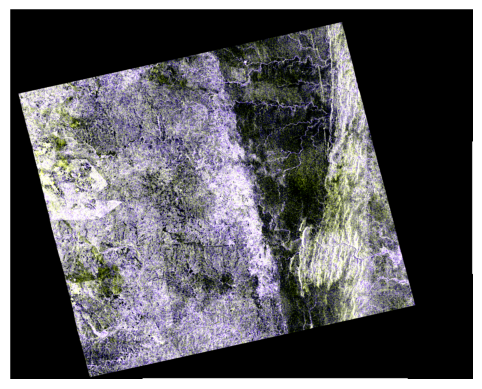

In [7]:

c2Folder =  r'./NISAR/GSLC_DP/rlee_3x3/C2'
# pst.dxpRGB(c2Folder,type=1)
# pst.dxpRGB(c2Folder,type=2)
# pst.dxpRGB(c2Folder,type=3)
pst.dxpRGB(c2Folder,type=4)

#### 4. Generating some polarimetric parameters from C2 matrix

##### 4.1 Barakat Degree of polarization 
##### using `polsartools.dopdp` function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/functions/dual_pol/DOP_dp.html) or run `print(polsartools.dopdp.__.doc__)`


In [8]:

pst.dopdp(c2Folder)


Progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.46block/s]


Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\dopdp.tif
Execution time for dopdp: 9.00 seconds


##### Preview the output

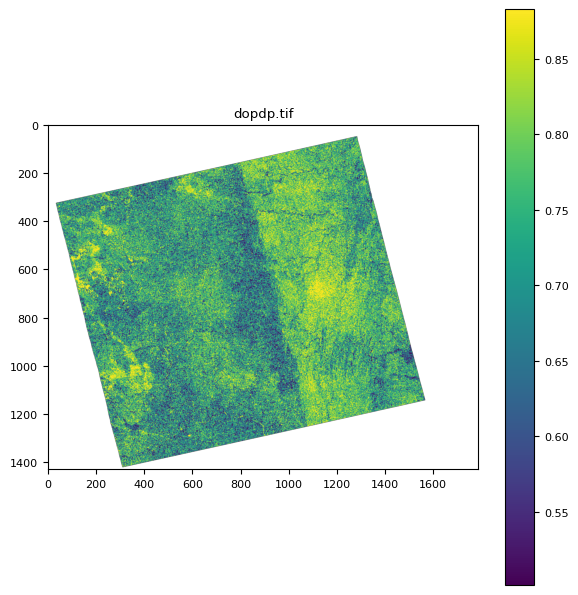

In [9]:

plot_images(c2Folder+'/dopdp.tif', lower_percentile=2, upper_percentile=98)

##### 4.2. Entropy-Alpha (H/α) parameters 
##### using **`polsartools.halphadp`** function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/functions/dual_pol/halphadxp.html) or run `print(polsartools.halphadp.__.doc__)`


In [10]:
pst.halphadp(c2Folder)


Progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:20<00:00,  1.70s/block]


Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\Hdp.tif
Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\alphadp.tif
Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\e1_norm.tif
Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\e2_norm.tif
Execution time for halphadp: 23.00 seconds


##### Preview the output

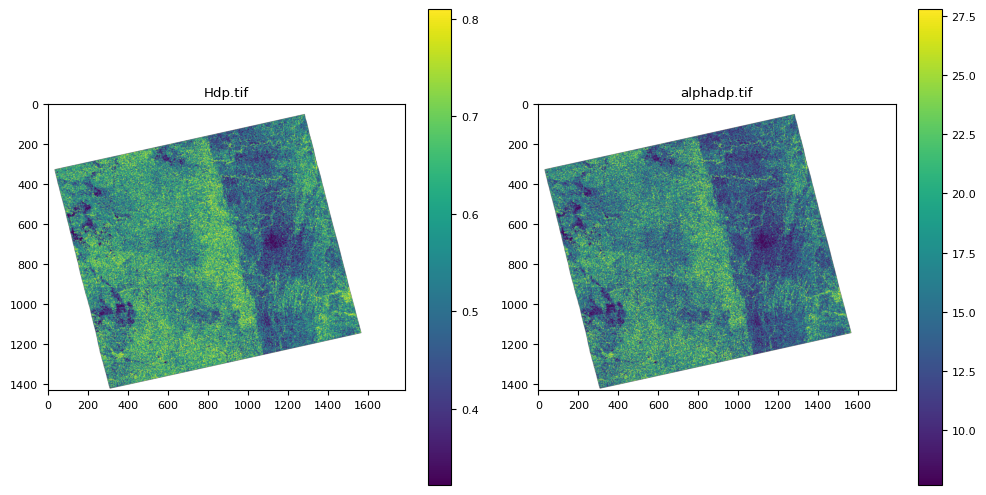

In [11]:


plot_images(c2Folder+'/Hdp.tif', 
            c2Folder + '/alphadp.tif',
            lower_percentile=2, upper_percentile=98)



##### Plot Entropy-Alpha plot for dual-pol
##### using **`polsartools.halpha_plot_dp`** function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/functions/dual_pol/halpha_plot_dp.html) or run `print(polsartools.halpha_plot_dp.__.doc__)`

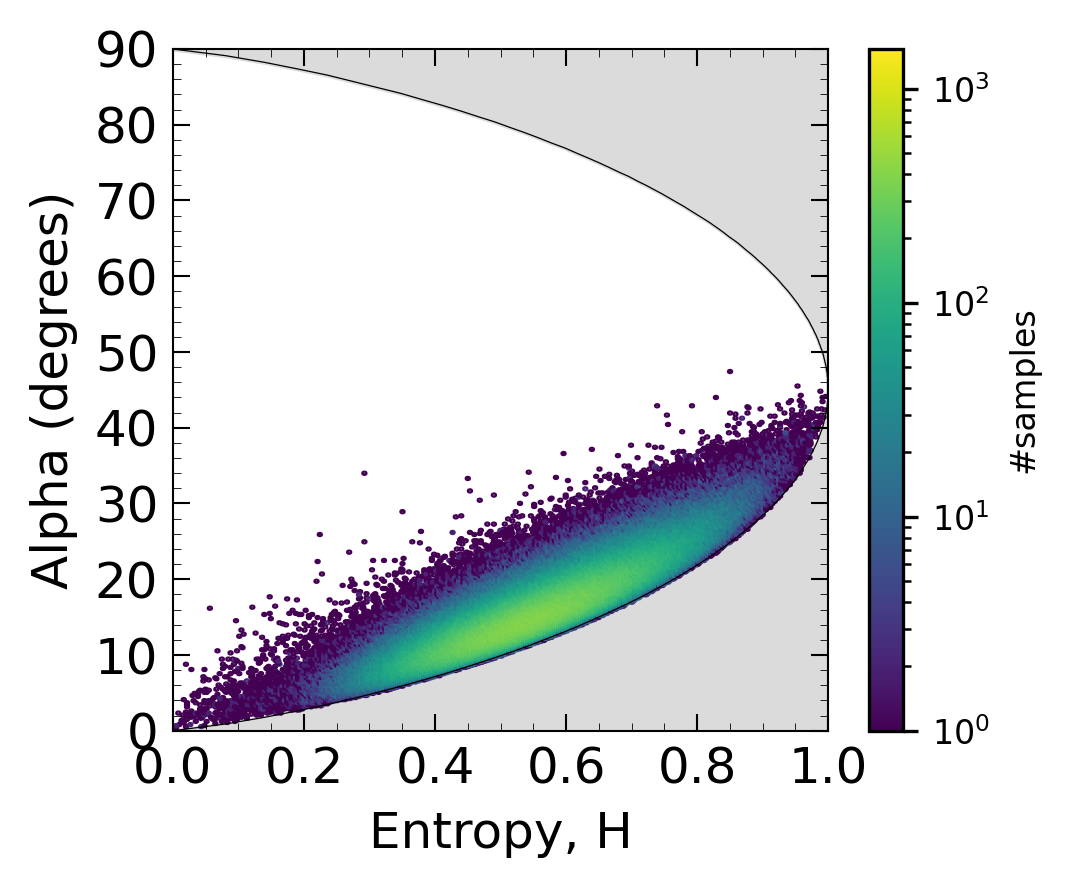

In [14]:
hFile = c2Folder + '/Hdp.tif'
alphaFile = c2Folder + '/alphadp.tif'

pst.halpha_plot_dp(hFile,alphaFile,norm='log')

##### 4.3. Shannon Entropy parameters (SE is the sum of contributions from intensity (SEI) and polarimetry (SEP))
##### using **`polsartools.shannon_h_dp`** function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/functions/dual_pol/shannon_h_dp.html) or run `print(polsartools.shannon_h_dp.__.doc__)`

In [15]:
pst.shannon_h_dp(c2Folder,window_size = 3)

Progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.88s/block]


Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\H_Shannon.tif
Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\HI_Shannon.tif
Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\HP_Shannon.tif
Execution time for shannon_h_dp: 38.00 seconds


##### Preview the output

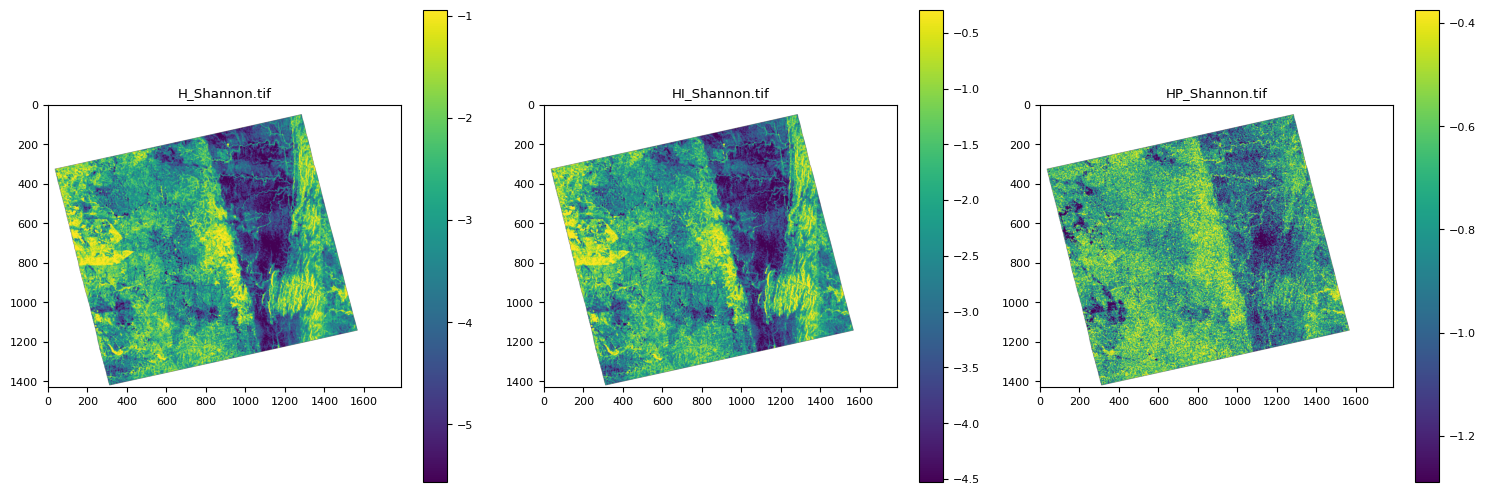

In [16]:

plot_images(c2Folder+'/H_Shannon.tif', 
            c2Folder + '/HI_Shannon.tif',
            c2Folder + '/HP_Shannon.tif',
            
            lower_percentile=2, upper_percentile=98)


##### 4.4. vegetation indices, Radar vegetation index (RVI), Dual-pol Radar Vegetation Index (DpRVI)

##### using **`polsartools.rvidp`** function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/functions/dual_pol/RVI_dp.html) or run `print(polsartools.rvidp.__.doc__)`

##### using **`polsartools.dprvi`** function, [click here for documentation](https://polsartools.readthedocs.io/en/latest/files/functions/dual_pol/DpRVI.html) or run `print(polsartools.dprvi.__.doc__)`




In [17]:

pst.rvidp(c2Folder)

pst.dprvi(c2Folder)


Progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:18<00:00,  1.56s/block]


Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\rvidp.tif
Execution time for rvidp: 20.00 seconds


Progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.37block/s]


Saved file ./NISAR/GSLC_DP/rlee_3x3/C2\dprvi.tif
Execution time for dprvi: 9.00 seconds


##### Preview the output

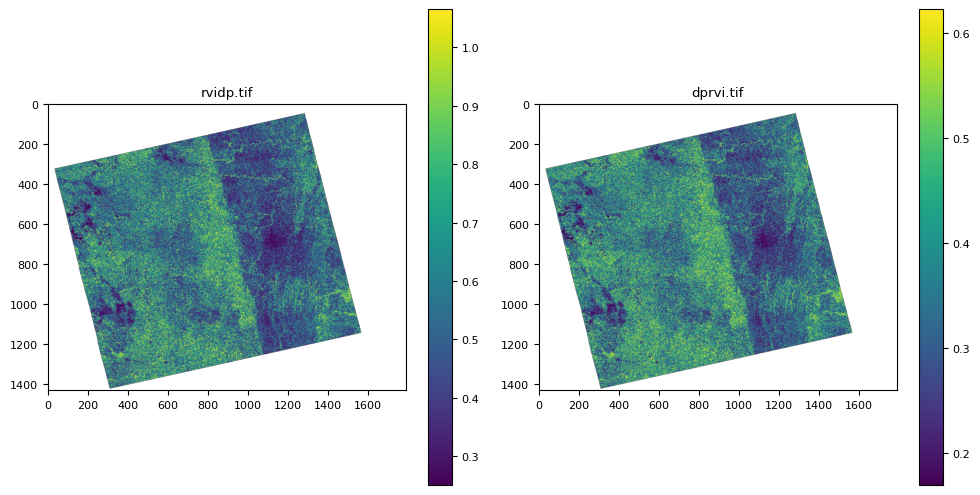

In [18]:

plot_images(c2Folder+'/rvidp.tif', 
            c2Folder + '/dprvi.tif',           
            lower_percentile=2, upper_percentile=98)
